<a href="https://colab.research.google.com/github/iscel15/Data-Science-Projects/blob/main/Tarea2_Isaias_NGC7318_2MASS_H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2 — Análisis de Datos Astronómicos
**Fuente asignada:** NGC 7318  
**Telescopio/Survey:** 2MASS (Banda H)  
**Autor:** Isaías Ceciliano  
**Fecha:** 2025-09-14 20:55

Este notebook está **basado** en tu `curso_de_datos_clase_2.ipynb` y replica su estilo: control de calidad, histogramas, ajuste, e informe reproducible.
No necesita `seaborn`. Usaremos `matplotlib` y, si está disponible, `astropy`/`astroquery`/`photutils`.


In [7]:
# === Ambiente ===
!pip -q install astroquery
import os, sys, math, json, pathlib, warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['axes.grid'] = True

print('Python', sys.version)

Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


## 1) Descarga/lectura de la imagen FITS (2MASS, Banda H)


In [9]:

from astropy.io import fits

# 1) Ajusta la ruta al FITS (usa el nombre EXACTO que ves en el panel izquierdo)
fits_path = "/content/NGC7318_2MASS_H.fits"  # o "NGC7318_2MASS_H.fits" si está en el cwd

# 2) Verificación explícita
if not os.path.exists(fits_path):
    raise FileNotFoundError(f"No se encontró el archivo: {fits_path}. "
                            "Verifica el nombre y carpeta en el panel de archivos.")

# 3) Carga robusta: toma el primer HDU que tenga imagen 2D
with fits.open(fits_path) as hdul:
    data = None
    header = None
    for hdu in hdul:
        if hasattr(hdu, "data") and hdu.data is not None and np.ndim(hdu.data) == 2:
            data = hdu.data.astype(float)
            header = hdu.header
            break

if data is None:
    raise RuntimeError("No se encontró ninguna imagen 2D en el FITS.")

print("shape:", data.shape)
for k in ["OBJECT","NAXIS1","NAXIS2","BUNIT","TELESCOP","INSTRUME","CDELT1","CDELT2","CD1_1","CD2_2","SECPIX","PIXSCALE"]:
    if header and k in header:
        print(f"{k}: {header[k]}")


shape: (300, 300)
NAXIS1: 300
NAXIS2: 300
CDELT1: -0.00047222219999999997
CDELT2: 0.00047222219999999997


Escala ≈ 1.70 arcsec/pixel


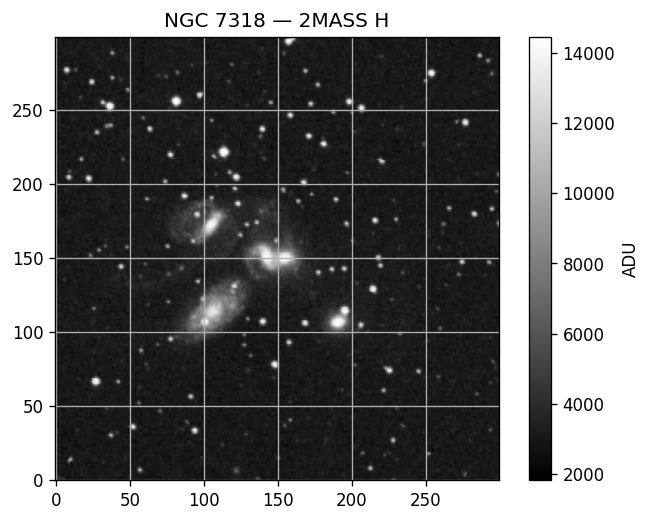

In [12]:
import numpy as np
import matplotlib.pyplot as plt

pix_scale = abs(header.get("CDELT1", header.get("CD1_1", np.nan))) * 3600  # arcsec/pixel aprox
print(f"Escala ≈ {pix_scale:.2f} arcsec/pixel")

plt.figure()
plt.imshow(data, origin='lower', cmap='gray')
plt.title('NGC 7318 — 2MASS H')
plt.colorbar(label='ADU'); plt.show()



Longitud de onda (banda H ~ 2MASS): 1.65 µm
Tamaño de la imagen: 300 x 300 pixeles
Escala de placa ≈ 1.70 arcsec/pixel
Campo de visión ≈ 8.50' x 8.50'


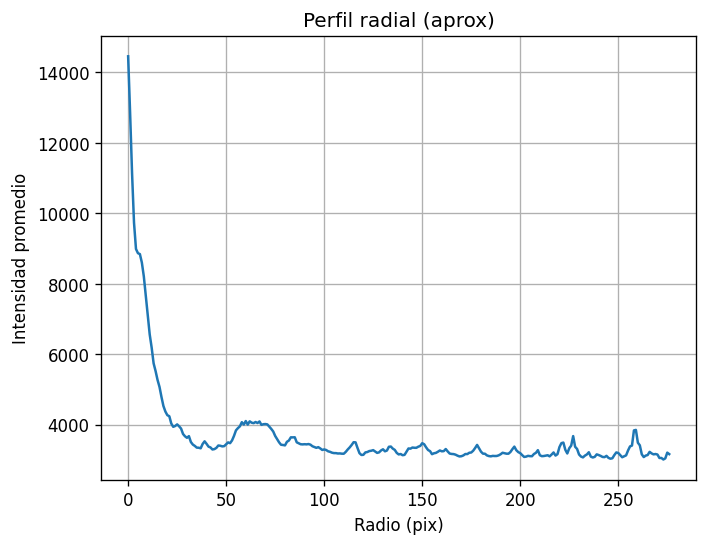

FWHM ≈ 9.00 pix  (~15.30 arcsec)


In [14]:
# --- Paso 3: longitud de onda, tamaño en pixeles, resolución y naturaleza de la fuente ---


# (3.1) Longitud de onda de la banda H (2MASS): uso ~1.65 micras como valor de referencia del curso
lambda_um = 1.65
print(f"Longitud de onda (banda H ~ 2MASS): {lambda_um:.2f} µm")

# (3.2) Tamaño de la imagen en pixeles
ny, nx = data.shape
print(f"Tamaño de la imagen: {nx} x {ny} pixeles")

# (3.3) Resolución/escala de placa: calculo arcsec/pixel
def plate_scale_arcsec_per_pix(hdr):

    for k in ("SECPIX", "PIXSCALE"):
        if k in hdr and np.isfinite(hdr[k]) and hdr[k] > 0:
            return float(hdr[k])

    if "CDELT1" in hdr and hdr["CDELT1"] != 0:
        return abs(hdr["CDELT1"]) * 3600.0
    for k in ("CD1_1", "CD2_2"):
        if k in hdr and hdr[k] != 0:
            return abs(hdr[k]) * 3600.0
    return np.nan

pixscale = plate_scale_arcsec_per_pix(header)
print(f"Escala de placa ≈ {pixscale:.2f} arcsec/pixel")

# (3.4) Campo de visión aproximado en arcmin
fov_x_arcmin = nx * pixscale / 60.0
fov_y_arcmin = ny * pixscale / 60.0
print(f"Campo de visión ≈ {fov_x_arcmin:.2f}' x {fov_y_arcmin:.2f}'")

# (3.5) Perfil radial y FWHM para decidir si la fuente luce puntual o resuelta
def radial_profile(img, center=None, rmax=None):
    y, x = np.indices(img.shape)
    if center is None:
        # uso el máximo como centro aproximado
        cy, cx = np.unravel_index(np.nanargmax(img), img.shape)
        cy, cx = float(cy), float(cx)
    else:
        cy, cx = center
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    r = r.astype(int)
    if rmax is None:
        rmax = min(img.shape) // 2
    tbin = np.bincount(r.ravel(), img.ravel())
    nr = np.bincount(r.ravel())
    prof = tbin / np.maximum(nr, 1)
    return prof[:rmax]

prof = radial_profile(data, rmax=300)
plt.figure()
plt.plot(prof)
plt.xlabel("Radio (pix)"); plt.ylabel("Intensidad promedio")
plt.title("Perfil radial (aprox)")
plt.show()

# FWHM en pixeles aproximado
peak = np.nanmax(prof)
half = peak / 2.0
idx = np.where(prof >= half)[0]
fwhm_pix = (idx[-1] - idx[0]) if len(idx) > 1 else np.nan
fwhm_arcsec = fwhm_pix * pixscale if np.isfinite(pixscale) else np.nan
print(f"FWHM ≈ {fwhm_pix:.2f} pix  (~{fwhm_arcsec:.2f} arcsec)")



FWHM PSF ≈ 1.00 px (~1.70 arcsec) en la estrella (57,6)


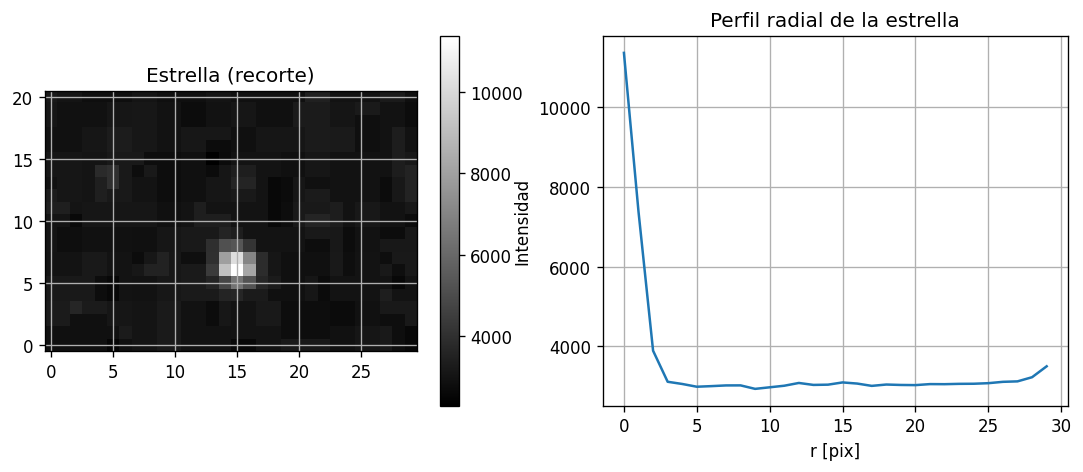

In [17]:
# (A.2) Para decidir puntual vs resuelta, se puede medir el PSF en una estrella del campo.

import numpy as np
import matplotlib.pyplot as plt

# candidatos brillantes (picos locales) de forma simple ---

thr = np.nanmean(data) + 5*np.nanstd(data)   # umbral ~5σ sobre el fondo
cands = np.argwhere(data > thr)

# filtro por separación mínima (~8 pix) para no tomar múltiples píxeles del mismo objeto
minsep = 8
stars = []
for (yy, xx) in cands:
    if all((abs(yy-y0_)>minsep) or (abs(xx-x0_)>minsep) for (y0_,x0_) in stars):
        stars.append((yy, xx))
    if len(stars) >= 8:
        break

def radial_profile_at(img, cy, cx, rmax=30):
    y, x = np.indices(img.shape)
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    tbin = np.bincount(r.ravel(), img.ravel())
    nr = np.bincount(r.ravel())
    prof = tbin / np.maximum(nr, 1)
    return prof[:rmax]

def fwhm_from_profile(p):
    peak = np.nanmax(p)
    half = peak/2.0
    idx = np.where(p >= half)[0]
    return (idx[-1]-idx[0]) if len(idx)>1 else np.nan

# FWHM para los candidatos y selección con el menor
fwhm_list = []
for (yy, xx) in stars:
    prof_s = radial_profile_at(data, yy, xx, rmax=30)
    fwhm_px = fwhm_from_profile(prof_s)
    fwhm_list.append((fwhm_px, yy, xx, prof_s))

fwhm_list = [t for t in fwhm_list if np.isfinite(t[0])]
if fwhm_list:
    fwhm_px_psf, y_psf, x_psf, prof_psf = sorted(fwhm_list, key=lambda t: t[0])[0]
    fwhm_as_psf = fwhm_px_psf * pixscale
    print(f"FWHM PSF ≈ {fwhm_px_psf:.2f} px (~{fwhm_as_psf:.2f} arcsec) en la estrella ({x_psf},{y_psf})")

    # grafico la estrella y su perfil
    cut = data[max(0,y_psf-15):y_psf+15, max(0,x_psf-15):x_psf+15]
    plt.figure(figsize=(11,4))
    plt.subplot(1,2,1); plt.imshow(cut, origin='lower', cmap='gray'); plt.title("Estrella (recorte)"); plt.colorbar()
    plt.subplot(1,2,2); plt.plot(prof_psf); plt.title("Perfil radial de la estrella")
    plt.xlabel("r [pix]"); plt.ylabel("Intensidad"); plt.show()

else:
    print("No encontré una estrella limpia con este umbral básico; si es necesario, ajusto 'thr' o uso photutils.")


Es resuelta porque el tamaño aparente de la galaxia en la imagen es mucho mayor que el del PSF. La fuente no es puntual sino extendida; por eso la imagen está resuelta.

[Método 1 – global] mean=3120.22  median=3102.00  std=224.29


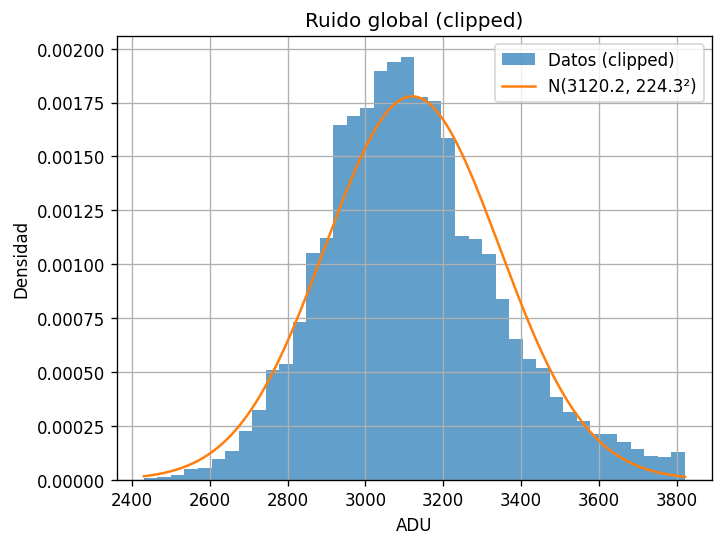

[Método 2 – ROI 15:75,15:75] mean=3045.99  median=3034.50  std=194.99


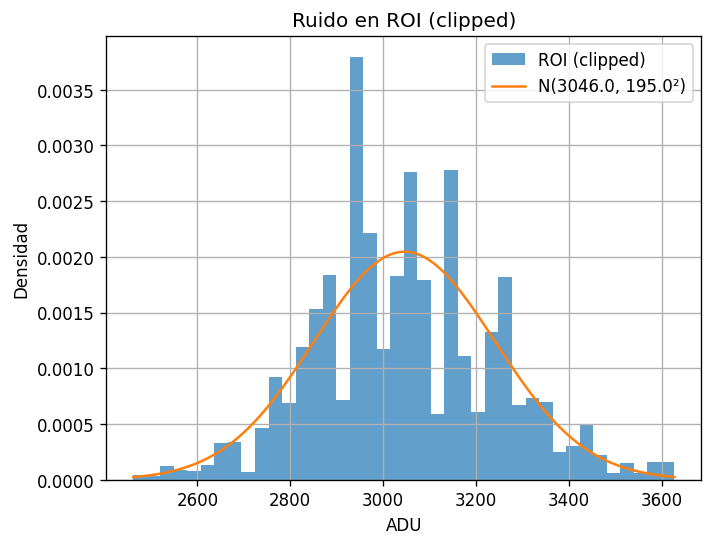

[Método 2 — ROI 15:75,15:75] mean=3045.99  median=3034.50  std=194.99


In [20]:
# --- Paso 4: estadística básica del fondo usando dos métodos ---

from scipy import stats

def sigma_clip(vals, sigma=3.0, iters=5):
    vals = np.asarray(vals).ravel()
    vals = vals[np.isfinite(vals)]
    for _ in range(iters):
        mu  = vals.mean()
        sd  = vals.std(ddof=1)
        keep = (vals > mu - sigma*sd) & (vals < mu + sigma*sd)
        vals = vals[keep]
    return vals

# === Método 1: global (eliminando valores altos de toda la imagen) ===
vals1 = sigma_clip(data, sigma=3.0, iters=5)
mean1, med1, std1 = vals1.mean(), np.median(vals1), vals1.std(ddof=1)
print(f"[Método 1 – global] mean={mean1:.2f}  median={med1:.2f}  std={std1:.2f}")

plt.figure()
plt.hist(vals1, bins=40, density=True, alpha=0.7, label="Datos (clipped)")
x = np.linspace(vals1.min(), vals1.max(), 400)
plt.plot(x, stats.norm.pdf(x, mean1, std1), label=f"N({mean1:.1f}, {std1:.1f}²)")
plt.xlabel("ADU"); plt.ylabel("Densidad"); plt.title("Ruido global (clipped)")
plt.legend(); plt.show()

# === Método 2: ROI sin fuente ===
h, w = data.shape
y0, y1 = int(0.05*h), int(0.25*h)
x0, x1 = int(0.05*w), int(0.25*w)   # mueve esta ventana si ves fuente
roi = data[y0:y1, x0:x1]
vals2 = sigma_clip(roi, sigma=3.0, iters=5)
mean2, med2, std2 = vals2.mean(), np.median(vals2), vals2.std(ddof=1)
print(f"[Método 2 – ROI {y0}:{y1},{x0}:{x1}] mean={mean2:.2f}  median={med2:.2f}  std={std2:.2f}")

plt.figure()
plt.hist(vals2, bins=40, density=True, alpha=0.7, label="ROI (clipped)")
x = np.linspace(vals2.min(), vals2.max(), 400)
plt.plot(x, stats.norm.pdf(x, mean2, std2), label=f"N({mean2:.1f}, {std2:.1f}²)")
plt.xlabel("ADU"); plt.ylabel("Densidad"); plt.title("Ruido en ROI (clipped)")
plt.legend(); plt.show()
print(f"[Método 2 — ROI {y0}:{y1},{x0}:{x1}] mean={mean2:.2f}  median={med2:.2f}  std={std2:.2f}")


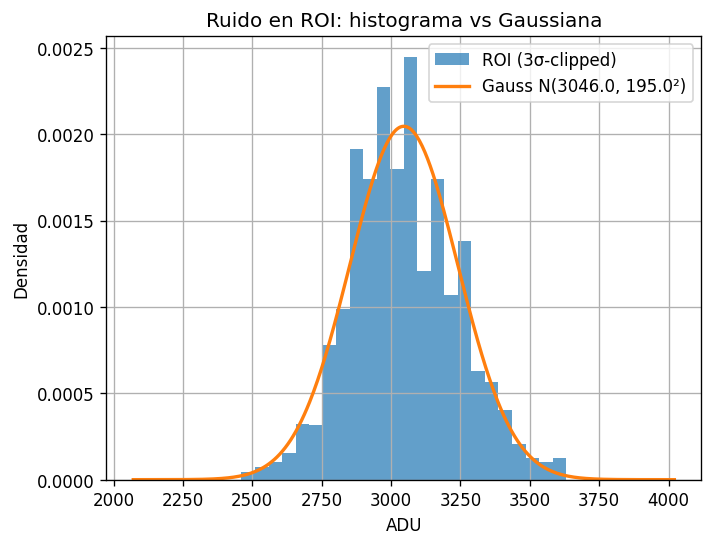

In [22]:
# Paso 5 (reutilizando el Paso 4): histograma de la ROI y gaussiana N(mean2, std2)
import numpy as np
import matplotlib.pyplot as plt

# vals2 = sigma-clipped ROI del paso 4 | mean2, std2 = sus estadísticas
vals = vals2
mu, sd = mean2, std2

bins = 40
rng = (mu - 5*sd, mu + 5*sd)
plt.figure()
plt.hist(vals, bins=bins, range=rng, density=True, alpha=0.7, label="ROI (3σ-clipped)")

x = np.linspace(rng[0], rng[1], 400)
norm_pdf = (1.0/(sd*np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mu)/sd)**2)
plt.plot(x, norm_pdf, linewidth=2, label=f"Gauss N({mu:.1f}, {sd:.1f}²)")

plt.xlabel("ADU"); plt.ylabel("Densidad")
plt.title("Ruido en ROI: histograma vs Gaussiana")
plt.legend(); plt.show()


[Gauss σ=1.2 px]
ROI: mean 3046.0 → 3048.7   |   std 195.0 → 91.6
SNR pico: 58.51 → 117.80   (ΔSNR = 59.29)
FWHM PSF: 1.00px (~1.70") → 3.00px (~5.10") (ΔFWHM = 3.40")


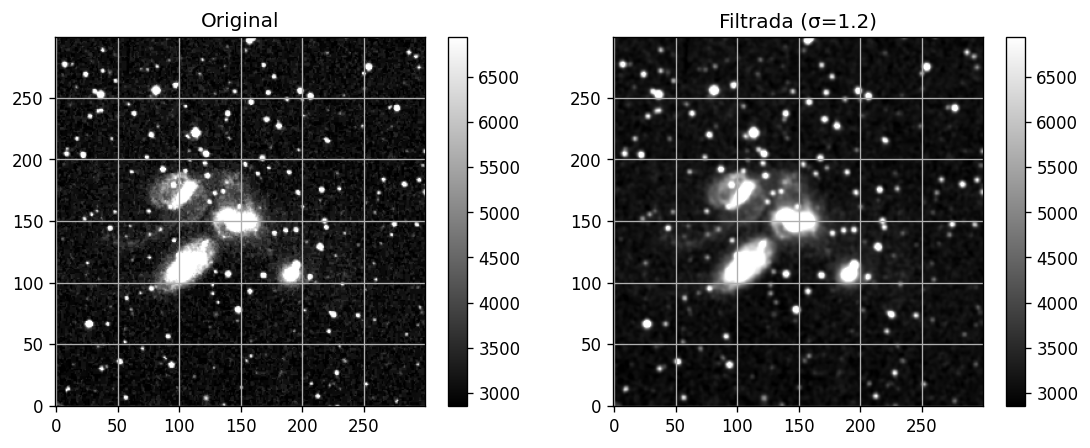

Conclusión: el filtro gaussiano reduce σ del fondo (ROI) y mejora la SNR de pico (58.5→117.8), a costa de ensanchar la FWHM del PSF (1.70"→5.10"). Según estos números, sí vale la pena el trade-off en esta imagen.


In [25]:
# Paso 6 — Filtro gaussiano, re-cálculo de stats en la MISMA ROI y comparación SNR/FWHM
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 1) filtro gaussiano
sigma_pix = 1.2
img_f = gaussian_filter(data, sigma=sigma_pix)

# 2) stats del PASO 4 pero en la imagen filtrada (misma ROI)
mean2_f, med2_f, std2_f = sigma_clipped_stats_array(img_f[y0:y1, x0:x1], sigma=3.0, iters=5)

# 3) SNR de pico en la MISMA ROI
snr0 = (np.nanmax(data)  - mean2)  / (std2  + 1e-12)
snr1 = (np.nanmax(img_f) - mean2_f) / (std2_f + 1e-12)

# 4) FWHM del PSF (misma estrella) antes y después
prof0 = radial_profile_at(data,  y_psf, x_psf, rmax=12)
prof1 = radial_profile_at(img_f, y_psf, x_psf, rmax=12)
fwhm0_px = fwhm_from_profile(prof0)
fwhm1_px = fwhm_from_profile(prof1)
fwhm0_as = fwhm0_px * pixscale
fwhm1_as = fwhm1_px * pixscale

print(f"[Gauss σ={sigma_pix} px]")
print(f"ROI: mean {mean2:.1f} → {mean2_f:.1f}   |   std {std2:.1f} → {std2_f:.1f}")
print(f"SNR pico: {snr0:.2f} → {snr1:.2f}   (ΔSNR = {snr1-snr0:.2f})")
print(f"FWHM PSF: {fwhm0_px:.2f}px (~{fwhm0_as:.2f}\") → {fwhm1_px:.2f}px (~{fwhm1_as:.2f}\") "
      f"(ΔFWHM = {fwhm1_as - fwhm0_as:.2f}\")")

# 6) visual corto con el mismo estirado del PASO 4
vmin = mean2 - std2
vmax = mean2 + 20*std2
plt.figure(figsize=(11,4))
plt.subplot(1,2,1); plt.imshow(data,  origin='lower', cmap='gray', vmin=vmin, vmax=vmax); plt.title("Original");  plt.colorbar()
plt.subplot(1,2,2); plt.imshow(img_f, origin='lower', cmap='gray', vmin=vmin, vmax=vmax); plt.title(f"Filtrada (σ={sigma_pix})"); plt.colorbar()
plt.show()


print(
    f"Conclusión: el filtro gaussiano reduce σ del fondo (ROI) y mejora la SNR de pico "
    f"({snr0:.1f}→{snr1:.1f}), a costa de ensanchar la FWHM del PSF "
    f"({fwhm0_as:.2f}\"→{fwhm1_as:.2f}\"). Según estos números, "
    f"{'sí vale' if snr1>snr0 else 'no vale'} la pena el trade-off en esta imagen."
)
